# Preprocessing

### Load libraries, load file, and add sos/eos tokens

In [1]:
# load libraries
import pandas as pd
import numpy as np
import tensorflow
import os, re, string
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [2]:
# load file
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) # print 5 random samples/rows

전체 샘플의 수 : 197463


,eng,fra,cc
134232,Could you tell me what time it is?,Pourrais-tu me donner l'heure ?,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
94654,I couldn't sleep last night.,Je n'ai pu dormir la nuit dernière.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
133052,We don't have a landline anymore.,Nous n'avons plus de ligne fixe.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
107686,You should get your hair cut.,Tu devrais te couper les cheveux.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
133454,Who knows what's going to happen?,Qui sait ce qui va avoir lieu ?,CC-BY 2.0 (France) Attribution: tatoeba.org #3...


In [3]:
lines = lines[['eng', 'fra']][:33000] # 33000 rows to be used
lines.sample(5)

,eng,fra
13638,Guys are stupid.,Les mecs sont stupides.
23375,He lives frugally.,Il vit de manière frugale.
7456,I made a list.,Je fis une liste.
24022,I hope this works.,J'espère que ça fonctionne.
1566,Try it on.,Essaie-le !


In [4]:
# add sos and eos tokens
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


,eng,fra
24294,I owe you a favor.,\t Je vous dois une faveur. \n
9558,You're sleepy.,\t Tu es endormie. \n
22865,Did you know that?,\t Le savais-tu ? \n
18428,I am out of work.,\t Je suis sans travail. \n
21652,We're dozing off.,\t Nous nous assoupissons. \n


In [5]:
lines.head(8)

,eng,fra
0,Go.,\t Va ! \n
1,Go.,\t Marche. \n
2,Go.,\t En route ! \n
3,Go.,\t Bouge ! \n
4,Hi.,\t Salut ! \n
5,Hi.,\t Salut. \n
6,Run!,\t Cours ! \n
7,Run!,\t Courez ! \n


# Regex

### 2 functions used for regex: 1 for English punctuations and 1 for French punctuations

In [6]:
# regex reference: https://stackoverflow.com/questions/64125019/how-to-tokenize-punctuations-using-the-tokenizer-function-tensorflow
def pad_punctuation(s): return re.sub(f"([{string.punctuation}])", r' \1 ', s)

# regex French punctuations
def french_punctuations(s):
    s = re.sub('[\u202f\u2009\xa0]', '', s)
    s = re.sub('’', " ' ", s)
    s = re.sub('[—––]', ' - ', s)
    s = re.sub('[«»]', ' " ', s)
    return s

In [7]:
# French punctuations and unicode spaces found in French list
# \u202f # unicode whitespace
# \u2009 # unicode whitespace
# \xa0 # unicode whitespace
# ’ # French apostrophe
# — # French hyphen
# – # French hyphen
# – # French hyphen
# «, » # French double quotes
# \u202f\u2009\xa0’—––«»

In [8]:
# create a full list from lines.fra and separate by common punctuation
lines.fra = [pad_punctuation(s) for s in lines.fra]
lines.fra[50:60]

50              \t Bonjour  !  \n
51                \t Salut  !  \n
52          \t Je comprends .  \n
53                   \t Aha .  \n
54            \t J ' essaye .  \n
55         \t J ' ai gagné  !  \n
56    \t Je l ' ai emporté  !  \n
57            \t J’ai gagné .  \n
58               \t Oh non  !  \n
59           \t Calme - toi .  \n
Name: fra, dtype: object

In [9]:
# create a full list from lines.fra and separate by French punctuation
lines.fra = [french_punctuations(s) for s in lines.fra]
lines.fra[50:60]

50              \t Bonjour  !  \n
51                \t Salut  !  \n
52          \t Je comprends .  \n
53                   \t Aha .  \n
54            \t J ' essaye .  \n
55         \t J ' ai gagné  !  \n
56    \t Je l ' ai emporté  !  \n
57          \t J ' ai gagné .  \n
58               \t Oh non  !  \n
59           \t Calme - toi .  \n
Name: fra, dtype: object

In [10]:
# create a full list from lines.eng and separate by punctuation
lines.eng = [pad_punctuation(s) for s in lines.eng]
lines.eng.head()

0    Go . 
1    Go . 
2    Go . 
3    Go . 
4    Hi . 
Name: eng, dtype: object

# Tokenization

### Tokenizing English & French data, find vocab, and length of the longest sentence

In [11]:
eng_tokenizer = Tokenizer(filters='')                       # Tokenizing by word
eng_tokenizer.fit_on_texts(lines.eng)                       # Tokenizing 33000 Eng rows
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # words into num sequence
input_text[:3]

[[29, 1], [29, 1], [29, 1]]

In [12]:
eng_tokenizer.index_word[6], eng_tokenizer.index_word[5], eng_tokenizer.index_word[1]

('tom', '?', '.')

In [13]:
fra_tokenizer = Tokenizer(filters='')                         # Tokenizing by word
fra_tokenizer.fit_on_texts(lines.fra)                         # Tokenizing 33000 Eng rows
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # words into num sequence
target_text[:3]

[[1, 74, 10, 2], [1, 339, 3, 2], [1, 27, 489, 10, 2]]

In [14]:
fra_tokenizer.index_word[1], fra_tokenizer.index_word[2]

('\t', '\n')

In [15]:
# find vocab size
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4713
프랑스어 단어장의 크기 : 8595


In [16]:
# find the length of the longest sentence
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 10
프랑스어 시퀀스의 최대 길이 20


In [17]:
# stats of English and French
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4713
프랑스어 단어장의 크기 : 8595
영어 시퀀스의 최대 길이 10
프랑스어 시퀀스의 최대 길이 20


### Ender and decoder preprocessing with removing tokens and adding padding seq

In [18]:
# raw input of English
encoder_input = input_text
# removing eos token for Fr input
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# removing sos token for Fr target
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [19]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 74, 10], [1, 339, 3], [1, 27, 489, 10]]
[[74, 10, 2], [339, 3, 2], [27, 489, 10, 2]]


In [20]:
# add padding sequence
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 10)
프랑스어 입력데이터의 크기(shape) : (33000, 20)
프랑스어 출력데이터의 크기(shape) : (33000, 20)


In [21]:
print(encoder_input[0])

[29  1  0  0  0  0  0  0  0  0]


In [22]:
# used for one-hot-encoding. This loads all data to a memory, use with caution as it can shutdown the kernel during overflow
# when used, loss func to be categorical_crossentropy instead of sparse_categorical_crossentropy, since ohe already done

# encoder_input = to_categorical(encoder_input)
# decoder_input = to_categorical(decoder_input)
# decoder_target = to_categorical(decoder_target)
# print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
# print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
# print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

### Splitting encoder and decoder data

In [23]:
# split encoder decoder train and test
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))
print('enc_inp_tr', np.shape(encoder_input_train))
print('dec_inp_tr', np.shape(decoder_input_train))
print('dec_tgt_tr', np.shape(decoder_target_train))
print('enc_inp_ts', np.shape(encoder_input_test))
print('dec_inp_ts', np.shape(decoder_input_test))
print('dec_tgt_ts', np.shape(decoder_target_test))

영어 학습데이터의 크기(shape) : (33000, 10)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 20)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 20)
enc_inp_tr (30000, 10)
dec_inp_tr (30000, 20)
dec_tgt_tr (30000, 20)
enc_inp_ts (3000, 10)
dec_inp_ts (3000, 20)
dec_tgt_ts (3000, 20)


# Training model

In [24]:
# encoder model
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, 300, input_length=max_eng_seq_len)(encoder_inputs)
encoder_lstm = LSTM(256, return_state=True, dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

In [25]:
# decoder model
# input tensor
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(fra_vocab_size, 300, input_length=max_fra_seq_len)(decoder_inputs)
# LSTM with 256 units of hidden size
decoder_lstm = LSTM(256, return_sequences = True, return_state=True, dropout=0.2)
# decoder_outputs is all time steps hidden state
decoder_outputs, _, _= decoder_lstm(dec_emb, initial_state = encoder_states)

In [26]:
# softmax for classification
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [27]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    1413900     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    2578500     input_2[0][0]                    
______________________________________________________________________________________________

In [28]:
# model train
early_stopping = EarlyStopping(patience=4) # add early stopping

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=512, epochs=150, callbacks=early_stopping) # batch size changed from 128 to 256 to 512

Epoch 1/150
59/59 [==============================] - 10s 91ms/step - loss: 2.3437 - val_loss: 1.8368
Epoch 2/150
59/59 [==============================] - 5s 81ms/step - loss: 1.4621 - val_loss: 1.5863
Epoch 3/150
59/59 [==============================] - 5s 82ms/step - loss: 1.2641 - val_loss: 1.4584
Epoch 4/150
59/59 [==============================] - 5s 83ms/step - loss: 1.1282 - val_loss: 1.3469
Epoch 5/150
59/59 [==============================] - 5s 85ms/step - loss: 1.0318 - val_loss: 1.2771
Epoch 6/150
59/59 [==============================] - 5s 84ms/step - loss: 0.9643 - val_loss: 1.2187
Epoch 7/150
59/59 [==============================] - 5s 85ms/step - loss: 0.9046 - val_loss: 1.1787
Epoch 8/150
59/59 [==============================] - 5s 85ms/step - loss: 0.8487 - val_loss: 1.1398
Epoch 9/150
59/59 [==============================] - 5s 85ms/step - loss: 0.8010 - val_loss: 1.1010
Epoch 10/150
59/59 [==============================] - 5s 85ms/step - loss: 0.7603 - val_loss: 1.069

dict_keys(['loss', 'val_loss'])


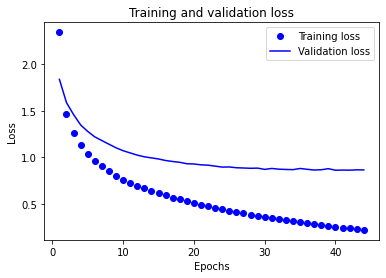

In [29]:
# plot loss
history_dict = history.history
print(history_dict.keys()) # keys to check parameters for plotting

# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is "dotted blue"
plt.plot(epochs, loss, 'bo', label='Training loss')
# "b" is "blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Testing model

In [30]:
# encoder model: use encoder_inputs and encoder_states defined earlier 
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         1413900   
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 570368    
Total params: 1,984,268
Trainable params: 1,984,268
Non-trainable params: 0
_________________________________________________________________


In [31]:
# decoder model
# previous time step's tensor with hidden state
decoder_state_input_h = Input(shape=(256,))
# previous time step's tensor with cell state
decoder_state_input_c = Input(shape=(256,))
# previous time step's tensor with hidden state and cell state in one variable
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs: use current time step as inital data/time step
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state = decoder_states_inputs)
# curernt time step's hidden state and cell state into decoder_states
decoder_states = [state_h, state_c]

In [32]:
# decoder's output model
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    2578500     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [33]:
# dictionary for word to index and index to word for both English and French from eng_tokenizer and fra_tokenizer
# needed to understand test results
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [34]:
# define decode_sequence function for prediction/translation
# decode_sequence()'s input is integer sequence of to be translated sentence
# decode_sequence() has encoder model inside for encoding
# when entered 'input_seq'(sentence int seq to be translated), encoder_model returns last hidden state
# 'this' hidden state becomes decoder's first hidden state and decoder predicts to create translated sentence
# during decoder pred process, model uses previous predicted words as current state's input
# this process ends when met with eos token or becomes longer than the length of the longest French sentence, which is 20
def decode_sequence(input_seq):
    # receives encoder state as input
    states_value = encoder_model.predict(input_seq)

    # creates one-hot-vector for <SOS>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = fra2idx['\t']

    stop_condition = False
    decoded_sentence = ""

    # run while loop until stop_condition becomes True
    while not stop_condition:
        # previous states_value to be used as current initial state
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # change pred result into words
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # add pred words to predicted sentence
        decoded_sentence += ' ' + sampled_char

        # end when reached <eos> or length of the longest French sentence, which is 20
        if (sampled_char == '\n' or len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # current state's pred result saved to be used as next state's input
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # current state saved to be used as next state
        states_value = [h, c]

    return decoded_sentence

In [35]:
# use for loop to input random samples word index and predict output results
for seq_index in [1,10,30,50,63,80,98,120,400,801]: # input words' index
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # print without sos and eos tokens
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # print without sos token

-----------------------------------
입력 문장: Go . 
정답 문장:  Marche .  
번역기가 번역한 문장:  en route ! 
-----------------------------------
입력 문장: Run ! 
정답 문장:  Filez  !  
번역기가 번역한 문장:  cours ! 
-----------------------------------
입력 문장: Help ! 
정답 문장:  À l ' aide !  
번역기가 번역한 문장:  aide ! 
-----------------------------------
입력 문장: Hello ! 
정답 문장:  Bonjour  !  
번역기가 번역한 문장:  salut ! 
-----------------------------------
입력 문장: Relax . 
정답 문장:  Cool ,  Raoul !  
번역기가 번역한 문장:  tranquille . 
-----------------------------------
입력 문장: Buy it . 
정답 문장:  Achète - le  !  
번역기가 번역한 문장:  achète - la ! 
-----------------------------------
입력 문장: Got it ? 
정답 문장:  Pigé ?  
번역기가 번역한 문장:  est - ce que ça a gagn
-----------------------------------
입력 문장: I ' m 19 . 
정답 문장:  J ' ai 19 ans .  
번역기가 번역한 문장:  j ' ai 19 ans . 
-----------------------------------
입력 문장: Shut up ! 
정답 문장:  Ferme - la !  
번역기가 번역한 문장:  ferme - la ! 
-----------------------------------
입력 문장: They won . 
정답 문장:  Ils ont gagné .  
번역기가

# 회고

1회차
- TypeError: Inputs to a layer should be tensors. Got: <keras.layers.embeddings.Embedding object at 0x7f05a2a51d30> 문제가 계속 생겼었다.
    - 타입 에러가 뭔지는 알지만, 고치는 방법을 찾지 못했었다.
    - https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html 여기를 가서 모델 빌딩을 따라해 보자는 마음가짐으로 한번 훑어보다가 고치는 방법을 알아내었다. Shape을 정해주고 난 후에 (encoder_inputs)을 옆에 붙여줌으로써 해결하였다.
- TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType' 라는 문제가 decoding model을 만드는 과정에서 에러가 생겼다.
    - 하도 에러가 계속 나서 천천히 훑어보고 모델링 셀을 다 지우고 다시 차분히 만들어 보니 잘 되었다.
- 모델을 결국 만들고 나서 학습을 시켜보려고 하니 커널이 죽어버렸다... 다음 회차때 해결해봐야 겠다.

2회차
- 커널이 죽는 이유를 도움을 받아 알아냈다. tf module중 to_categorical이란 셀이 있는데, one-hot-encoding을 하는 기능을 가지고 있는데, 이 셀을 실행하고 나서 계속 진행하려고 하면, 메모리 초과로 모델 학습을 못하고 커널이 죽어버리는 현상이 일어났었다.
    - 이 셀을 없애고 모델의 metrics를 categorical_crossentropy에서 sparse_categorical_crossentropy로 바꿔주니 잘 학습이 되었다.
- 프로젝트를 진행하다가 french list에서 이상한 문장들이 있다는 것을 알아냈다.
    - '\u202f\u2009\xa0’—––«»' 이 문자들이 있었고, 구두점만 단어와 분리해놨어서 따로 추가 전처리가 필요해졌다.
    - project 06 에서 배운 regex re.sub을 이용해 성공적으로 전처리를 하였다.
- 학습 진행 후, 시각화를 해 보았다.

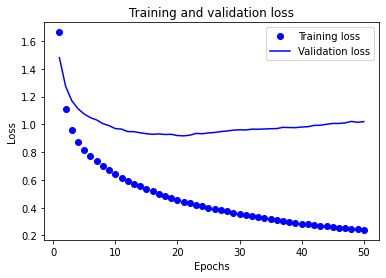

3회차
- test 모델을 만들어 진행해 보았다.
    - test modeling 부분에서 계속 에러가 났다.
        - ValueError: Input 0 of layer lstm_1 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 1, 8595, 100)

4회차
- 마지막 셀, 번역 결과를 보는 코드에서 3회차부터 계속 에러가 났었다
    - 모델에서 여러가지를 더하고 바꿔보고 하다가 결국 노드에 코드를 보고선 구현할 수 있었다.
    - 번역 결과는 대부분 틀리는 것을 볼수가 있었다.
- epoch을 많이 올려 과적합을 하니 val_loss는 내려가다 올라갔지만, 번역 문장 결과는 오히려 좋은 결과를 나타내어 혼란을 가중시켰다.
    - 6개 이상을 맞추는 결과를 볼 수가 있어서 많이 헷갈렸다.
    - 과적합으로 인해 test 결과가 안좋아야 하는데 번역이 더 좋아지고 더 많이 맞춘다는 것이 이해가 가지 않았다.

5회차
- 생각한 목표대로 val_loss를 줄이기 위해 여러 hyperparameter를 바꿔봤다.
    - early stopping 추가
    - model.fit batch_size를 128에서 256으로 그리고 512로 바꾸기
    - encoder and decoder LSTM에 dropout 0.2 추가
    - embedding output dim 100에서 200으로 바꾸기
    - lstm unit을 계속 올려봤지만, 결과가 오히려 떨어지는 형태를 보여, 256으로 맞춰주었다.
- val_loss를 0.90 언저리로 만들수 있었지만, 10개의 문장을 번역해 보았을 때, 반 정도만 말이 되는 번역으로 출력되었다.
    - embedding output dim을 300으로 바꿔주며 val_loss를 0.85정도로 맞추니, 1번째와 7번째 문장만 틀리고 나머지 8개를 맞추는 결과를 볼수가 있었다.
    - learning_rate를 다양하게 두고 모델을 돌려봐도 비슷한 결과를 나타내었다.

# 배운점

- hyperparameter를 어떻게 설정하느냐에 따라 모델의 학습결과와 번역 문장의 결과가 비슷하게 또는 천차만별로 다르게 나타나는 것을 볼수가 있었다.
    - 모델을 설계할 시, hyperparameter를 적당히 설정해야 한다는 것을 배웠다.
    - 극단적인 설정은 오히려 결과를 나쁘게 하는 결과를 보였다.
- 이번에 사용한 것이 저번 프로젝트랑은 다르게 functional API 였는데, 처음 사용하는 것이라 많이 버벅거렸다.
    - Sequential API가 좀더 쉽게 설계한다는 생각이 들었다.
    

# 추가

- 왜 과적합시 hyperparameter를 설정하기 전보다 더 좋은 결과를 초래했을까?
- 모델 설계 과정?